In [10]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq


In [18]:
import re
import pandas as pd


files = [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_sorted.72h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_sorted.72h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_sorted.72h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_sorted.72h.rep4.star2.featurecounts.counts.txt'
    ]


def clean_count_column(s):
    return '.'.join(s.split('/')[-1].replace('.rna_seq.activated_sorted','.Sorted').replace('h.','hr.').split('.')[:4])
        
df = None
for f in files:
    df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
    df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
    if df is None:
        df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')
df.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.Sorted.72hr.counts.txt', sep='\t')

In [1]:
!head /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/mmTreg.Sorted.72hr.counts.txt

Geneid	Chr	Start	End	mmTreg.Sorted.72hr.rep1	mmTreg.Sorted.72hr.rep2	mmTreg.Sorted.72hr.rep3	mmTreg.Sorted.72hr.rep4	mmTh0.Sorted.72hr.rep1	mmTh0.Sorted.72hr.rep2	mmTh0.Sorted.72hr.rep3	mmTh0.Sorted.72hr.rep4
ENSMUSG00000102693.1	chr1	3073253	3074322	0	0	0	0	0	0	0	0
ENSMUSG00000064842.1	chr1	3102016	3102125	0	0	0	0	0	0	0	0
ENSMUSG00000051951.5	chr1;chr1;chr1;chr1	3205901;3213439;3421702;3670552	3207317;3216968;3421901;3671498	0	0	0	0	0	0	0	0
ENSMUSG00000102851.1	chr1	3252757	3253236	0	0	0	0	0	0	0	0
ENSMUSG00000103377.1	chr1	3365731	3368549	0	0	0	0	0	0	0	0
ENSMUSG00000104017.1	chr1	3375556	3377788	0	0	0	0	0	0	0	0
ENSMUSG00000103025.1	chr1	3464977	3467285	0	0	0	0	0	0	0	0
ENSMUSG00000089699.1	chr1;chr1	3466587;3513405	3466687;3513553	0	0	0	0	0	0	0	0
ENSMUSG00000103201.1	chr1	3512451	3514507	0	0	0	0	0	0	0	0


In [21]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/logs
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -p all \
    --mem 16G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/treg_sorted_72hr.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
     mmTreg.Sorted.72hr-mmTh0.Sorted.72hr \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON | cut -d"-" -f1)
Rscript /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3,4}) \
    --controls $(echo ${CONTROL}.rep{1,2,3,4}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq \
    --counts /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/${FACTOR}.counts.txt
    
EOF

Submitted batch job 26651325


In [3]:
%%bash
FDR=0.05
COMPARISONS=( \ 
     mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr \
)
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.txt |  cut -d. -f1 > ${COMP}.expressed_genes.txt 
    
    # Save significant upreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3>0)){print $1}}' |  cut -d. -f1 > ${COMP}.upreg_genes.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3<0)){print $1}}' |  cut -d. -f1 > ${COMP}.downreg_genes.txt 

done

In [4]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq
for ii in $(/bin/ls -1 *_vs_*hr.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [5]:
%%bash
FDR=0.05
COMPARISONS=( \
     mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr \
)
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.with_genes.txt |  awk '{print $NF}' > ${COMP}.expressed_genes.symbols.txt 

    # Save significant upreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3>0)){print $NF}}' > ${COMP}.upreg_genes.symbols.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3<0)){print $NF}}' > ${COMP}.downreg_genes.symbols.txt 

done



In [6]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq
module load ImageMagick/7.0.1-gcb01
for ii in $(/bin/ls -1 *.pdf);
do
    convert ${ii} ${ii/.pdf/.png}
done

convert: error while loading shared libraries: libtiff.so.3: cannot open shared object file: No such file or directory
convert: error while loading shared libraries: libtiff.so.3: cannot open shared object file: No such file or directory
convert: error while loading shared libraries: libtiff.so.3: cannot open shared object file: No such file or directory
convert: error while loading shared libraries: libtiff.so.3: cannot open shared object file: No such file or directory
convert: error while loading shared libraries: libtiff.so.3: cannot open shared object file: No such file or directory
convert: error while loading shared libraries: libtiff.so.3: cannot open shared object file: No such file or directory


====== mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000026131.18,4769.895642,3.270509,0.082133,0.0,0.0,Dst,protein_coding
29,ENSMUSG00000032323.13,1960.793551,6.748219,0.171882,0.0,0.0,Cyp11a1,protein_coding
30,ENSMUSG00000019970.15,3075.677574,6.519682,0.137918,0.0,0.0,Sgk1,protein_coding
31,ENSMUSG00000074785.5,2485.417105,-3.669086,0.091968,0.0,0.0,Plxnc1,protein_coding
32,ENSMUSG00000020027.18,9142.657298,3.419018,0.063708,0.0,0.0,Socs2,protein_coding
33,ENSMUSG00000041046.7,1442.682281,-5.288743,0.139538,0.0,0.0,Ramp3,protein_coding
34,ENSMUSG00000010142.12,17012.867820,2.960769,0.069014,0.0,0.0,Tnfrsf13b,protein_coding
35,ENSMUSG00000020900.15,7512.307798,-2.761949,0.062314,0.0,0.0,Myh10,protein_coding
36,ENSMUSG00000001507.16,2847.958470,-3.601991,0.093897,0.0,0.0,Itga3,protein_coding
37,ENSMUSG00000017493.12,7560.905806,3.705814,0.078819,0.0,0.0,Igfbp4,protein_coding


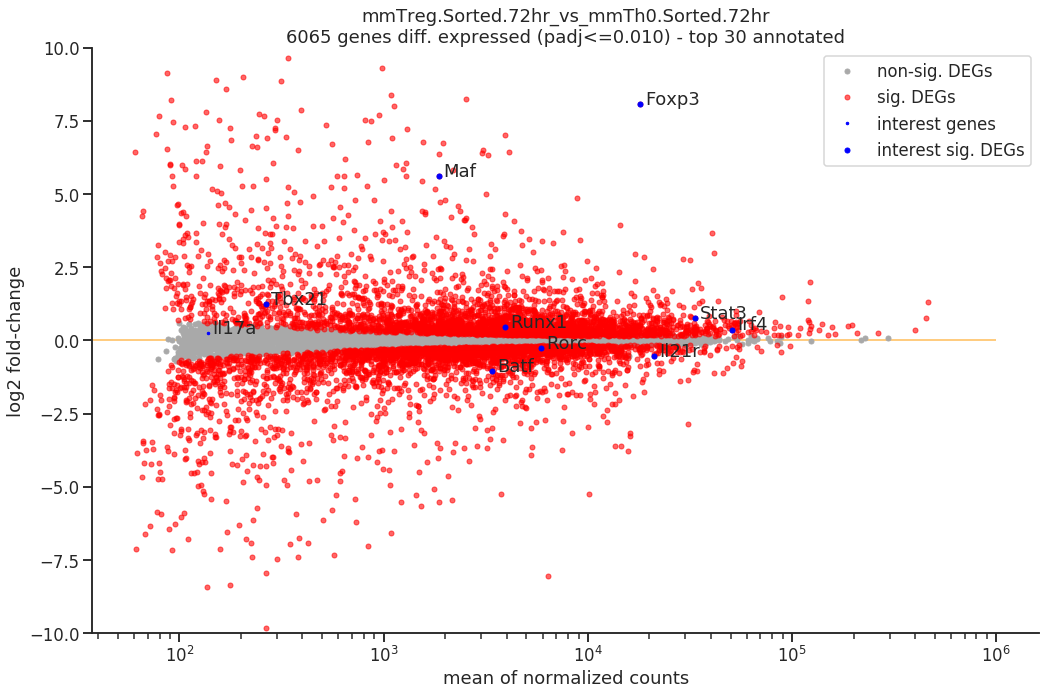

In [13]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 3
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30

special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
comparisons = [
     'mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr'
]

data_dir = '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(15,10))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values,'o', color='darkgrey', label='non-sig. DEGs', markersize=5)

    
    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values,'ro', alpha=0.6, label='sig. DEGs', markersize=5)

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    df_annotate_table = df_sig.sort_values(by='padj', ascending=True)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes', markersize=5)
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue',
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs', markersize=5)
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    
#     # Save annotated MA plot
    plt.savefig("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/degs.%s.with_genes.annotated_plot_MA.png" % comparison)
    plt.savefig("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/degs.%s.with_genes.annotated_plot_MA.pdf" % comparison)
     # Save annotated genes without pseudogenes
    df_annotate_table.to_csv("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/%s.with_genes.sig_DE.txt" % comparison,
                       sep='\t',
                       index=False)
    
    # print table of values 
    print ("======", comparison, "======")
    display(df_annotate) 



### DE analysis when the reference Th0.00hr

In [1]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr

In [2]:
import re
import pandas as pd

comp_files = {
    'mmTreg.Bulk.00hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTreg.Bulk.02hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTreg.Bulk.16hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTreg.Bulk.24hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTreg.Bulk.48hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTreg.Sorted.72hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ]
    
}


def clean_count_column(s):
    items = ['bulk', 'Bulk']
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    if name.startswith('mm'):
        if any(i in s for i in items):
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated_bulk','.Bulk').replace('h.','hr.').split('.')[:4])
        else:
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated','.Bulk').replace('h.','hr.').split('.')[:4])
        
    else:
        if any(i in s for i in items):
            split_words = '.'.join(s.split('.')[1:3])
            rev_words = '.'.join(list(reversed(s.split('.')[1:3])))
            return '.'.join(s.split('/')[-1].replace(split_words, rev_words).split('.')[:4])
        else:
            s = re.sub('17.', '17.Bulk.', s)
            return '.'.join(s.split('/')[-1].split('.')[:4])
        
        
for comp, files in comp_files.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')

    df.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/%s.counts.txt' % comp, sep='\t')

In [10]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -p all \
    --mem 16G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/treg_deseq_0hr_ref_48hr.out \
    <<'EOF'
#!/bin/bash
COMPARISON=( \
     mmTreg.Bulk.00hr-mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.24hr-mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.48hr-mmTh0.Bulk.00hr \ 
     )

TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON | cut -d"-" -f1)
Rscript /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3,4})  \
    --controls $(echo ${CONTROL}.rep{2,3,4}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr \
    --counts /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/${FACTOR}.counts.txt
    
EOF

Submitted batch job 26606520


In [8]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -p all \
    --array=0-2 \
    --mem 16G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/treg_deseq_0hr_ref_v2.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
     mmTreg.Bulk.02hr-mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.16hr-mmTh0.Bulk.00hr \ 
     )

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON | cut -d"-" -f1)
Rscript /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3,4})  \
    --controls $(echo ${CONTROL}.rep{2,3,4}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr \
    --counts /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/${FACTOR}.counts.txt
    
EOF

Submitted batch job 26606512


In [9]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -p all \
    --mem 16G \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/logs/treg_deseq_0hr_ref_v3.out \
    <<'EOF'
#!/bin/bash
COMPARISON=( \
   mmTreg.Sorted.72hr-mmTh0.Bulk.00hr \ 
)
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON | cut -d"-" -f1)
Rscript /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3,4})  \
    --controls $(echo ${CONTROL}.rep{2,3,4}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr \
    --counts /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/${FACTOR}.counts.txt
    
EOF

Submitted batch job 26606515


In [12]:
%%bash
FDR=0.05
COMPARISONS=( \ 
     mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr \
)
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.txt |  cut -d. -f1 > ${COMP}.expressed_genes.txt 
    
    # Save significant upreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3>0)){print $1}}' |  cut -d. -f1 > ${COMP}.upreg_genes.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3<0)){print $1}}' |  cut -d. -f1 > ${COMP}.downreg_genes.txt 

done

 

In [13]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr
for ii in $(/bin/ls -1 *_vs_*hr.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [14]:
%%bash
FDR=0.05
COMPARISONS=( \
     mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr \ 
     mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr \
)
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.with_genes.txt |  awk '{print $NF}' > ${COMP}.expressed_genes.symbols.txt 

    # Save significant upreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3>0)){print $NF}}' > ${COMP}.upreg_genes.symbols.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3<0)){print $NF}}' > ${COMP}.downreg_genes.symbols.txt 

done



In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 3
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30

special_genes = ['Ctla', 'Stat3', 'Stat5', 'Il10', 'Eomes', 'Runx1', 'Il21ra', 'Il7r', 'Foxp3']
comparisons = [
     'mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr', 
     'mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr' 
]

data_dir = '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(10,7))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values,'o', color='darkgrey', label='non-sig. DEGs', markersize=5)

    
    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values,'ro', alpha=0.6, label='sig. DEGs', markersize=5)

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    df_annotate_table = df_sig.sort_values(by='padj', ascending=True)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes', markersize=5)
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue',
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs', markersize=5)
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    
#     # Save annotated MA plot
    plt.savefig("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/degs.%s.with_genes.annotated_plot_MA.png" % comparison)
    plt.savefig("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/degs.%s.with_genes.annotated_plot_MA.pdf" % comparison)
     # Save annotated genes without pseudogenes
    df_annotate_table.to_csv("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/%s.with_genes.sig_DE.txt" % comparison,
                       sep='\t',
                       index=False)
    
    # print table of values 
#     print ("======", comparison, "======")
#     display(df_annotate) 



In [3]:
import pandas as pd

treg_48 = pd.read_csv('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/mmTreg.Bulk.48hr.counts.txt', sep='\t')
treg_48 = treg_48.drop(columns=['Chr','Start','End'])
#treg_48 = treg_48.set_index('Geneid')
treg_48

# gene_details = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM13/gencode.vM13.gene_id_to_gene_name.txt', 
#                               sep='\t',
#                              names = ['ensembl_id', 'gene_name', 'gene_type'])

# gene_id_to_name = dict(zip(gene_details['ensembl_id'], gene_details['gene_name']))
# treg_48['GeneName'] = [gene_id_to_name[k] for k in treg_48.index.values]
# treg_48 = treg_48.reset_index()

# cols = list(treg_48.columns)
# cols = [cols[-1]] + cols[:-1]
# treg_48 = treg_48[cols]
# treg_48 = treg_48.drop(columns='Geneid')

treg_48.to_csv('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/mmTreg.Bulk.48hr.raw_counts.txt', sep='\t')

In [8]:
import pandas as pd

files = [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.02h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.16h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.24h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated.48h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTreg.rna_seq.activated_sorted.72h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
 ]

def clean_count_column(s):
    items = ['sorted', 'Bulk']
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    if name.startswith('mm'):
        if any(i in s for i in items):
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated_sorted','.Sorted').replace('h.','hr.').split('.')[:4])
        else:
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated','.Bulk').replace('h.','hr.').split('.')[:4])
        
    else:
        if any(i in s for i in items):
            split_words = '.'.join(s.split('.')[1:3])
            rev_words = '.'.join(list(reversed(s.split('.')[1:3])))
            return '.'.join(s.split('/')[-1].replace(split_words, rev_words).split('.')[:4])
        else:
            s = re.sub('17.', '17.Bulk.', s)
            return '.'.join(s.split('/')[-1].split('.')[:4])
        
        

df = None
for f in files:
    df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
    df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
    if df is None:
        df = df_tmp.loc[:, [df_tmp.columns[-1]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')
df = df.reset_index()

df.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/counts/Treg_Th0.counts.txt', sep='\t')

### Comparison of DE genes before and after RUVSeq

In [2]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq
for ii in $(/bin/ls -1 *_vs_*hr.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

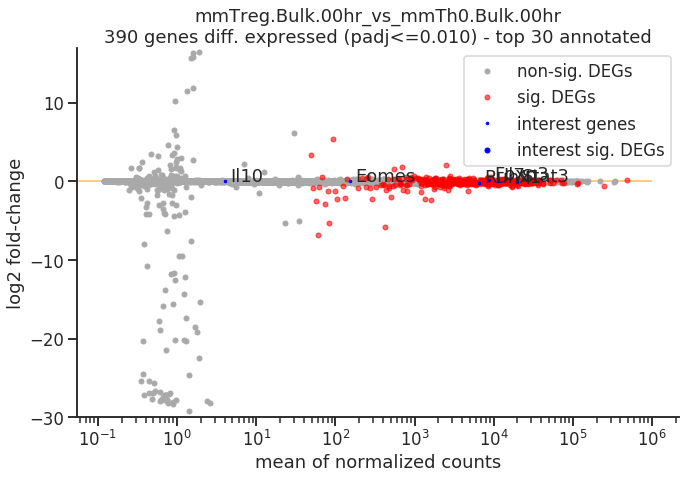

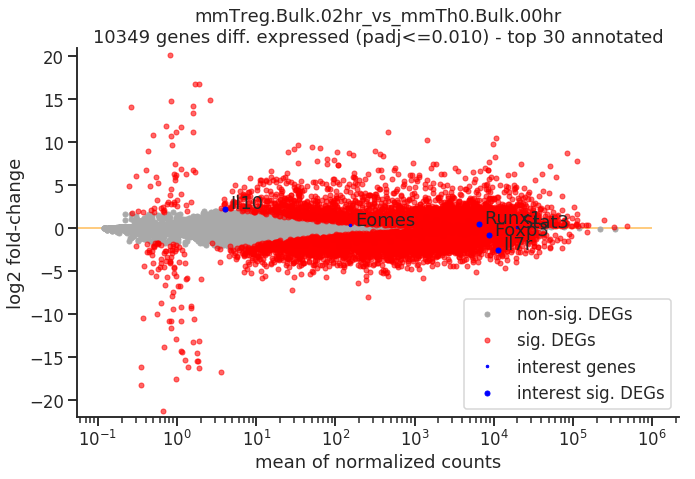

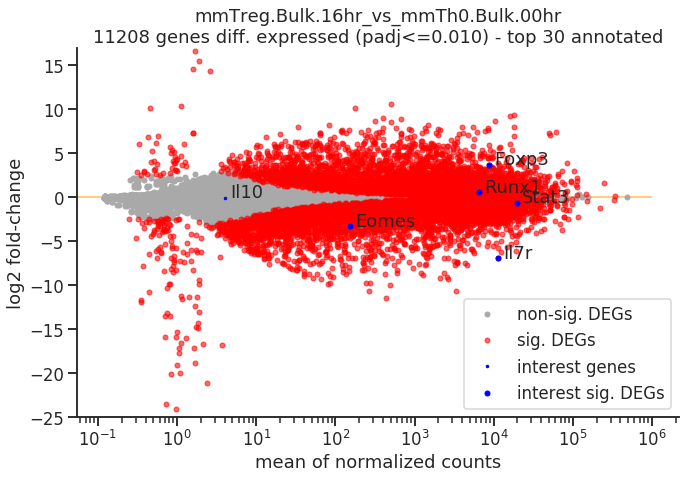

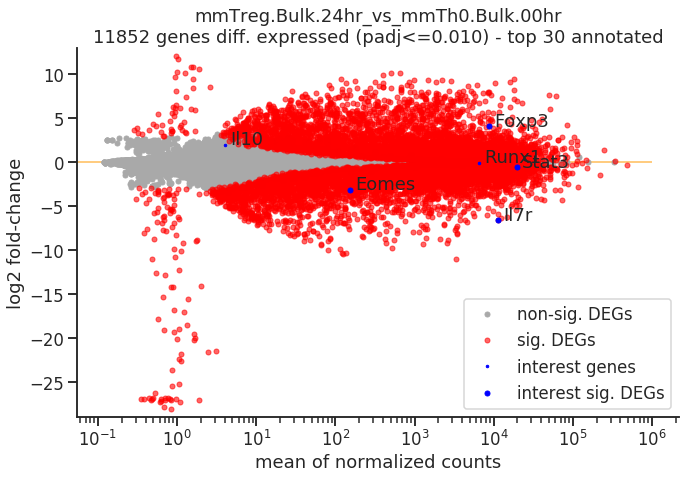

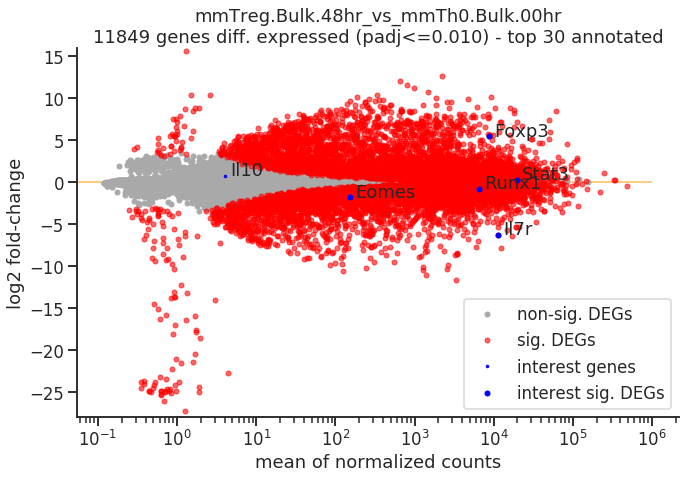

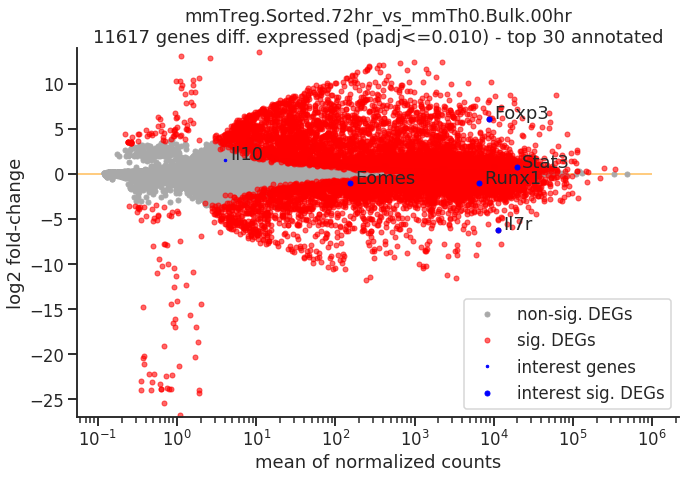

In [4]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 3
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30

special_genes = ['Ctla', 'Stat3', 'Stat5', 'Il10', 'Eomes', 'Runx1', 'Il21ra', 'Il7r', 'Foxp3']
comparisons = [
     'mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr', 
     'mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr',  
     'mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr' 
]

data_dir = '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(10,7))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values,'o', color='darkgrey', label='non-sig. DEGs', markersize=5)

    
    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values,'ro', alpha=0.6, label='sig. DEGs', markersize=5)

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    df_annotate_table = df_sig.sort_values(by='padj', ascending=True)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes', markersize=5)
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue',
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs', markersize=5)
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    plt.show()
    
#     # Save annotated MA plot
#     plt.savefig("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/degs.%s.with_genes.annotated_plot_MA.png" % comparison)
#     plt.savefig("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/degs.%s.with_genes.annotated_plot_MA.pdf" % comparison)
#      # Save annotated genes without pseudogenes
#     df_annotate_table.to_csv("/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/%s.with_genes.sig_DE.txt" % comparison,
#                        sep='\t',
#                        index=False)
    
    # print table of values 
#     print ("======", comparison, "======")
#     display(df_annotate) 



In [5]:
%%bash
ls /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/*.with_genes.sig_DE.txt

/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt


In [12]:
import pandas as pd

files = [
    '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt',
    '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt'
]

def clean_columns(f):
    return '.'.join(f.split('/')[-1].split('_')[:1])
    
df = None
for file in files:
    df_tmp = pd.read_csv(file, sep='\t')
    if 'stat' in df_tmp.columns.tolist():
        df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType', 'stat'], inplace = True)
    else:
        df_tmp.drop(columns = ['Unnamed: 0', 'baseMean', 'lfcSE', 'pvalue', 'padj', 'GeneType'], inplace = True)
        
    df_tmp = df_tmp[['GeneName', 'log2FoldChange']]
    df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_columns(file)]
    if df is None:
        df = df_tmp
    else:
        df = df.merge(df_tmp, how = 'outer', on = 'GeneName')
        
df = df[['GeneName','mmTreg.Bulk.00hr','mmTreg.Bulk.02hr','mmTreg.Bulk.16hr','mmTreg.Bulk.24hr','mmTreg.Bulk.48hr','mmTreg.Sorted.72hr']]
df.columns = [u'gene','00','02','16','24','48','72']
df = df.fillna(0)
df.to_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg_Th0.logFC.txt', sep='\t', index=False)



In [6]:
!head /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt

Unnamed: 0	baseMean	log2FoldChange	lfcSE	pvalue	padj	GeneName	GeneType
ENSMUSG00000023805.16	2509.3103353556	2.04336527390295	0.0692676530071577	9.70668799176959e-193	1.143156644790709e-188	Synj2	protein_coding
ENSMUSG00000047881.14	699.728288338685	1.78942529158389	0.124773175904221	1.16849883226651e-47	6.880705373801361e-44	Rell1	protein_coding
ENSMUSG00000106219.1	94.05717874560128	5.3814398890760895	0.407244791129496	5.582713586437418e-40	2.1915872635824496e-36	5830416I19Rik	lincRNA
ENSMUSG00000031143.4	553.092967889992	1.52595604485692	0.124710120874534	3.15700562655698e-35	9.295013815990392e-32	Ccdc22	protein_coding
ENSMUSG00000044026.2	2335.0792502951	-0.8395118808457249	0.0734218962200656	3.27854565208942e-33	7.722286428931409e-30	Slc35g1	protein_coding
ENSMUSG00000028961.15	8545.13282797744	-0.527201530788325	0.047512687926622006	4.66290613364483e-30	9.15250758932252e-27	Pgd	protein_coding
ENSMUSG00000025453.16	1816.10593562608	-0.771634706674611	0.0772143900371391	3.480791238

### Comparison between DE genes before and after RUVSeq

In [2]:
%%bash
ls /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/*.with_genes.sig_DE.txt
ls /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/*.with_genes.sig_DE.txt

/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr/mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt
/data/reddylab/Revat

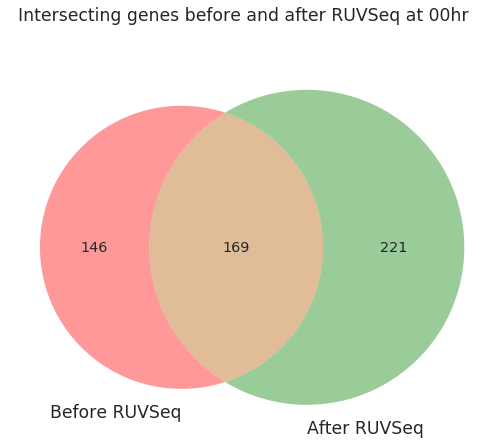

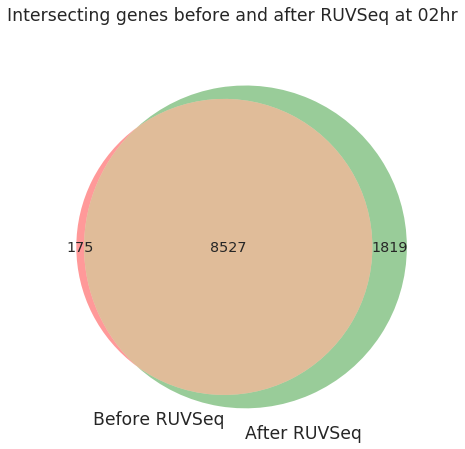

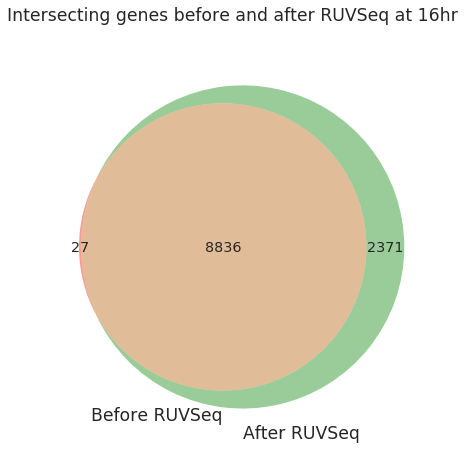

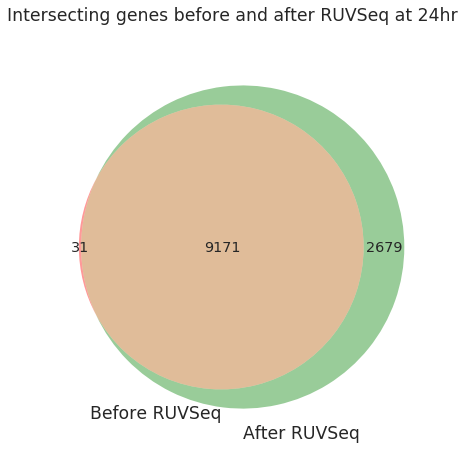

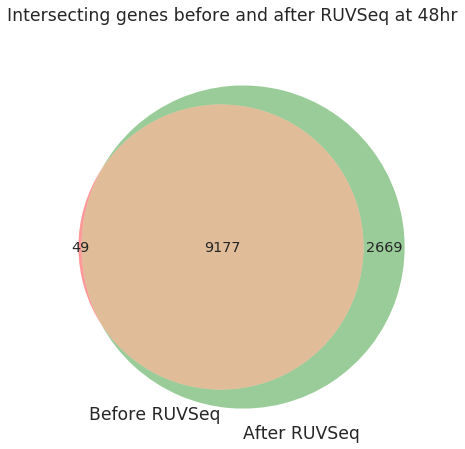

In [11]:
import pandas as pd
import matplotlib_venn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
# fig = plt.gcf()
# fig.set_size_inches(10,7)

before_dir = '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr'
after_dir = '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq'

time_stamps = ['00hr','02hr','16hr','24hr','48hr']
for time in time_stamps:
    bef_ruv = pd.read_csv('%s/mmTreg.Bulk.%s_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt' % (before_dir, time), sep='\t')
    aft_ruv = pd.read_csv('%s/mmTreg.Bulk.%s_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt' % (after_dir, time), sep='\t')
    bef_ruv_list = set(bef_ruv.GeneName.unique().tolist())
    aft_ruv_list = set(aft_ruv.GeneName.unique().tolist())
    fig = plt.gcf()
    fig.set_size_inches(10,7)
    venn2([bef_ruv_list,aft_ruv_list], ('Before RUVSeq', 'After RUVSeq'))
    plt.suptitle('Intersecting genes before and after RUVSeq at %s' % (time))
    plt.show()
    



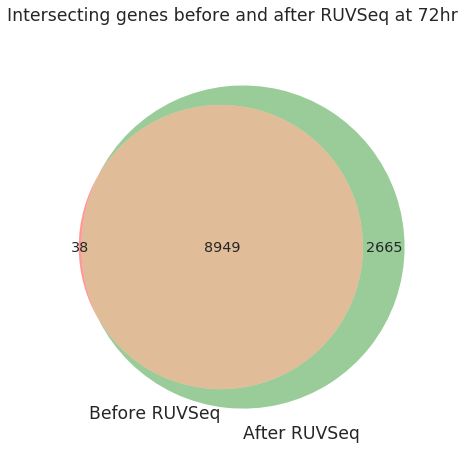

In [12]:
import pandas as pd
import matplotlib_venn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
# fig = plt.gcf()
# fig.set_size_inches(10,7)

before_dir = '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/0hr'
after_dir = '/data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq'

time_stamps = ['72hr']
for time in time_stamps:
    bef_ruv = pd.read_csv('%s/mmTreg.Sorted.%s_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt' % (before_dir, time), sep='\t')
    aft_ruv = pd.read_csv('%s/mmTreg.Sorted.%s_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt' % (after_dir, time), sep='\t')
    bef_ruv_list = set(bef_ruv.GeneName.unique().tolist())
    aft_ruv_list = set(aft_ruv.GeneName.unique().tolist())
    fig = plt.gcf()
    fig.set_size_inches(10,7)
    venn2([bef_ruv_list,aft_ruv_list], ('Before RUVSeq', 'After RUVSeq'))
    plt.suptitle('Intersecting genes before and after RUVSeq at %s' % (time))
    plt.show()
    



In [4]:
!head /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/ruvseq/mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr.with_genes.sig_DE.txt

Unnamed: 0	baseMean	log2FoldChange	lfcSE	pvalue	padj	GeneName	GeneType
ENSMUSG00000023805.16	2509.3103353556	2.04336527390295	0.0692676530071577	9.70668799176959e-193	1.143156644790709e-188	Synj2	protein_coding
ENSMUSG00000047881.14	699.728288338685	1.78942529158389	0.124773175904221	1.16849883226651e-47	6.880705373801361e-44	Rell1	protein_coding
ENSMUSG00000106219.1	94.05717874560128	5.3814398890760895	0.407244791129496	5.582713586437418e-40	2.1915872635824496e-36	5830416I19Rik	lincRNA
ENSMUSG00000031143.4	553.092967889992	1.52595604485692	0.124710120874534	3.15700562655698e-35	9.295013815990392e-32	Ccdc22	protein_coding
ENSMUSG00000044026.2	2335.0792502951	-0.8395118808457249	0.0734218962200656	3.27854565208942e-33	7.722286428931409e-30	Slc35g1	protein_coding
ENSMUSG00000028961.15	8545.13282797744	-0.527201530788325	0.047512687926622006	4.66290613364483e-30	9.15250758932252e-27	Pgd	protein_coding
ENSMUSG00000025453.16	1816.10593562608	-0.771634706674611	0.0772143900371391	3.480791238

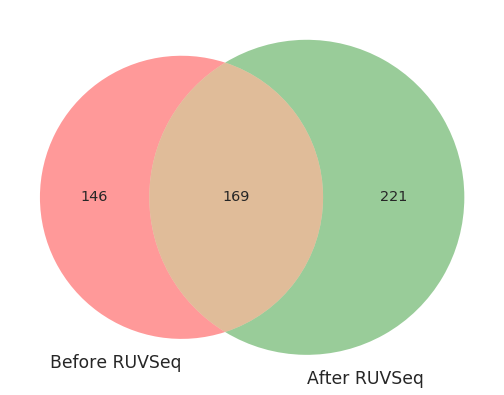

In [7]:
import matplotlib_venn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
fig = plt.gcf()
fig.set_size_inches(10,7)
venn2([bef_ruv_00_list,aft_ruv_00_list], ('Before RUVSeq', 'After RUVSeq'))
#venn4([unique_snp_ms_list, unique_snp_ibd_list, unique_snp_ra_list, unique_snp_ps_list], ('MS', 'IBD', 'RA', 'Psoriasis'))
#plt.suptitle('Unique SNPs that intersect with ATAC peaks for RA and Psoriasis')
plt.show()